In [1]:
import tensorflow as tf
from tensorflow import nn
import os
import  cv2
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import torch.nn as nn
import torch

In [3]:
import math
import pickle
from pathlib import Path
import sklearn.model_selection as SkMs
import sklearn.ensemble as SkE
import sklearn.metrics as SkM
import sklearn.linear_model as SkLm
import joblib
import sklearn.inspection as SkI
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

## Image cropping

In [4]:
def expand2square(img):
    '''adjust to square '''
    width, height=img.size
    if width == height:
        return img
    elif width > height:
        result=Image.new(img.mode,(width,width),'white')
        result.paste(img,(0,(width-height)//2))
        return result
    else:
        result=Image.new(img.mode,(height,height),'white')
        result.paste(img,((height-width)//2,0))
        return result

## Transition and smoothing

In [129]:
def prepro(file='test.png') :
    ''' Input image file path, output grayscale array '''
    img = Image.open(file).convert('L') # grayscale
    img = np.asarray(expand2square(img)) # adjust to square
    img = cv2.resize(img,(300,300),interpolation=cv2.INTER_CUBIC) # control size
    img = cv2.GaussianBlur(img,(5,5),0) # Gaussian Blur
    return img

## Hough Transformation

In [6]:
def HL_n(img, threshold=40):
    ''' input grayscale array, output (16,) array '''
    edges = cv2.Canny(img, 50, 150, apertureSize = 3)#Get the outline of the image
    lines = cv2.HoughLines(edges,1,np.pi/180,threshold)
    m = np.zeros((512,512))
    for line in lines:
        rho = line[0][0]
        theta = line[0][1]
        x = int(rho*np.cos(theta))
        y = int(rho*np.sin(theta))
        m[x, y] += 1
    bsize = 128
    return np.array([np.sum(m[i*bsize : (i+1)*bsize, j*bsize : (j+1)*bsize]) for j in range(4) for i in range(4)])

## Harris corner detection

In [7]:
def getHarris_feature(gray, dim=300, bsize=75):
    ''' The number of key points is 35, k=0.05, the window area for calculating gradient and differential is 10. Output (16,) array '''
    corners = cv2.goodFeaturesToTrack(gray, 35, 0.05, 10,useHarrisDetector=True)
    mat=np.zeros((dim,dim))
    for i in range(len(corners)):
        x=int(corners[i,0,0])
        y=int(corners[i,0,1])
        mat[x,y]=1
    n=dim/bsize
    f_list=list()
    for i in range(int(n)):
        for j in range(int(n)):
            f_list.append(np.sum(mat[i*bsize:(i+1)*bsize,j*bsize:(j+1)*bsize]))
    return np.array(f_list)

# Generate Dataframe

In [8]:
# filepath is an absolute path
def getFileName(filepath):
    df_final = pd.DataFrame(columns=range(1,33))
    pathList = os.listdir(filepath)
    for allFile in pathList:
        everyFile = os.path.join(filepath, allFile)# stitching file path
        a = prepro(everyFile)
        b=HL_n(a)
        c = getHarris_feature(a)
        d = np.hstack((b,c))
        e = pd.DataFrame(data = d).T
        df_final = pd.concat([e,df_final])

    return df_final

## Loading Data and Separating Train/Test


### First DataSet

In [9]:
wu = getFileName(r'C:\Users\xhw20\Desktop\dataset\wu')
wu.iloc[:,32]=1
name = list()
for i in range(len(wu)):
    name.append('wu_' + str(i))
wu.index = name

In [10]:
kang = getFileName(r'C:\Users\xhw20\Desktop\dataset\kang')
kang.iloc[:,32]=0
name = list()
for i in range(len(kang)):
    name.append('kang_' + str(i))
kang.index = name

In [11]:
yi = getFileName(r'C:\Users\xhw20\Desktop\dataset\yi')
yi.iloc[:,32]=0
name = list()
for i in range(len(yi)):
    name.append('yi_' + str(i))
yi.index = name

In [12]:
ji = getFileName(r'C:\Users\xhw20\Desktop\dataset\ji')
ji.iloc[:,32]=0
name = list()
for i in range(len(ji)):
    name.append('ji_' + str(i))
ji.index = name

In [13]:
fu = getFileName(r'C:\Users\xhw20\Desktop\dataset\fu')
fu.iloc[:,32]=0
name = list()
for i in range(len(fu)):
    name.append('fu_' + str(i))
fu.index = name

In [18]:
first_data = pd.concat([wu,kang,yi,ji,fu], axis = 0)
print(first_data.shape)
first_data.head()

(2197, 33)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
wu_0,26.0,9.0,1.0,0.0,16.0,1.0,0.0,1.0,2.0,0.0,...,5.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,2.0,1
wu_1,13.0,1.0,0.0,0.0,21.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,7.0,6.0,0.0,0.0,1.0,2.0,0.0,1
wu_2,10.0,0.0,0.0,3.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,7.0,3.0,0.0,0.0,0.0,2.0,0.0,1
wu_3,7.0,7.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,1.0,2.0,10.0,4.0,0.0,0.0,0.0,2.0,0.0,1
wu_4,12.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,8.0,4.0,0.0,0.0,3.0,3.0,0.0,1


In [21]:
#first_data.to_csv('/Users/gracean/Desktop/Data Mining/Project2/first_data.csv')

C:\Users\xhw20\.conda\envs\tensorflowgpu\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\xhw20\.conda\envs\tensorflowgpu\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

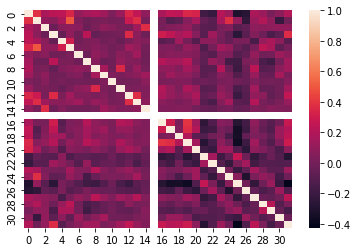

In [19]:
#df is dataframe what we need to build correlation matrix
df = first_data.iloc[:,0:32]
correlations =np.corrcoef(df.astype(float),rowvar=0)
import seaborn as sns
sns.set_context({"figure.figsize":(10,10)})
sns.heatmap(correlations)

### Second Dataset

In [21]:
shang = getFileName(r'C:\Users\xhw20\Desktop\The second dataset\shang')
shang.iloc[:,32]=0
name = list()
for i in range(len(shang)):
    name.append('shang_' + str(i))
shang.index = name

In [22]:
wan = getFileName(r'C:\Users\xhw20\Desktop\The second dataset\wan')
wan.iloc[:,32]=0
name = list()
for i in range(len(wan)):
    name.append('wan_' + str(i))
wan.index = name

In [23]:
ge = getFileName(r'C:\Users\xhw20\Desktop\The second dataset\ge')
ge.iloc[:,32]=0
name = list()
for i in range(len(ge)):
    name.append('ge_' + str(i))
ge.index = name

In [24]:
cheng = getFileName(r'C:\Users\xhw20\Desktop\The second dataset\cheng')
cheng.iloc[:,32]=0
name = list()
for i in range(len(cheng)):
    name.append('cheng_' + str(i))
cheng.index = name

In [26]:
second_data = pd.concat([wu,shang,wan,ge,cheng], axis = 0)
print(second_data.shape)
second_data.head()

(2197, 33)


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
wu_0,26.0,9.0,1.0,0.0,16.0,1.0,0.0,1.0,2.0,0.0,...,5.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,2.0,1
wu_1,13.0,1.0,0.0,0.0,21.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,7.0,6.0,0.0,0.0,1.0,2.0,0.0,1
wu_2,10.0,0.0,0.0,3.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,7.0,3.0,0.0,0.0,0.0,2.0,0.0,1
wu_3,7.0,7.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,1.0,2.0,10.0,4.0,0.0,0.0,0.0,2.0,0.0,1
wu_4,12.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,8.0,4.0,0.0,0.0,3.0,3.0,0.0,1


In [ ]:
#second_data.to_csv('/Users/gracean/Desktop/Data Mining/Project2/second_data.csv')

C:\Users\xhw20\.conda\envs\tensorflowgpu\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\xhw20\.conda\envs\tensorflowgpu\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

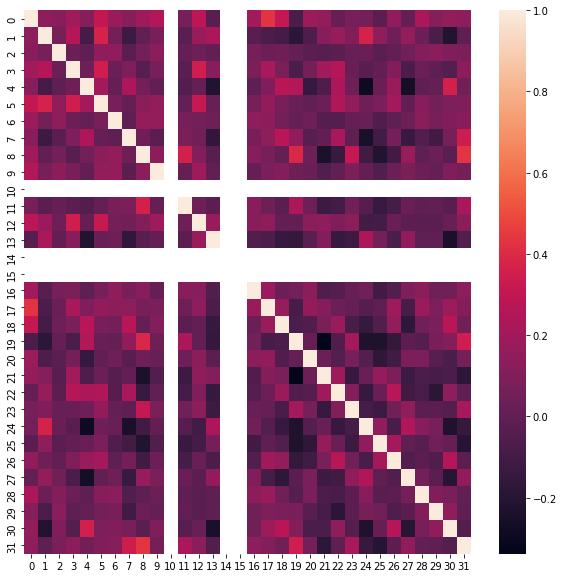

In [27]:
df2 = second_data.iloc[:,0:32]
correlations2 =np.corrcoef(df2.astype(float),rowvar=0)
import seaborn as sns
sns.set_context({"figure.figsize":(10,10)})
sns.heatmap(correlations2)

## Split Train and Test for random forest and logistic regression model

In [30]:
#Train v.s. Test set for first dataset
train_wu, test_wu = train_test_split(wu, test_size=0.2)
train_kang, test_kang = train_test_split(kang, test_size=0.2)
train_yi, test_yi = train_test_split(yi, test_size=0.2)
train_ji, test_ji = train_test_split(ji, test_size=0.2)
train_fu, test_fu = train_test_split(fu, test_size=0.2)

train_data_1 = pd.concat([train_wu,train_kang,train_yi, train_ji, train_fu],axis=0)
test_data_1 = pd.concat([test_wu, test_kang, test_yi, test_ji, test_fu], axis = 0)

train1_x = train_data_1.iloc[:,0:32]
train1_y =train_data_1.iloc[:,32]
test1_x = test_data_1.iloc[:,0:32]
test1_y =test_data_1.iloc[:,32]

In [31]:
#Train v.s. Test set for second dataset
train_wu, test_wu = train_test_split(wu, test_size=0.2)
train_cheng, test_cheng = train_test_split(cheng, test_size=0.2)
train_ge, test_ge = train_test_split(ge, test_size=0.2)
train_wan, test_wan = train_test_split(wan, test_size=0.2)
train_shang, test_shang = train_test_split(shang, test_size=0.2)

train_data_2 = pd.concat([train_wu,train_cheng,train_ge, train_wan, train_shang],axis=0)
test_data_2 = pd.concat([test_wu, test_cheng, test_ge, test_wan, test_shang], axis = 0)

train2_x = train_data_2.iloc[:,0:32]
train2_y =train_data_2.iloc[:,32]
test2_x = test_data_2.iloc[:,0:32]
test2_y =test_data_2.iloc[:,32]

## Model building

In [32]:
def plot_confusion_matrix(cm, labels_name, title):
    np.set_printoptions(precision=2)
    # print(cm)
    plt.imshow(cm, interpolation='nearest')    # Display the image on a specific window
    plt.title(title)    # title
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    
    plt.yticks(num_local, labels_name)  
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

### Model 0 “base rate” of natural turnover

In [33]:
test1_y.value_counts()

0    322
1    119
Name: 32, dtype: int64

In [34]:
p= 595/2197
ntest= 322+119
predict_ran = np.random.binomial(1, p, ntest)

confusion matrix:
 [[251  71]
 [ 91  28]]
confusion matrix:
 [[0.77950311 0.22049689]
 [0.76470588 0.23529412]]
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       322
           1       0.28      0.24      0.26       119

    accuracy                           0.63       441
   macro avg       0.51      0.51      0.51       441
weighted avg       0.61      0.63      0.62       441



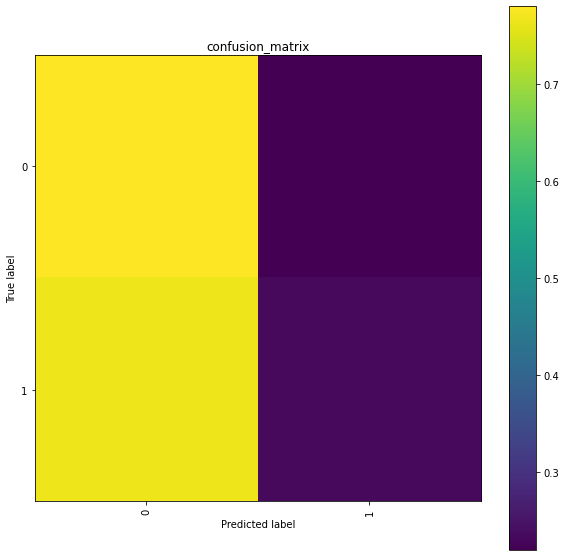

In [35]:
y_actual = pd.Series(test1_y, name='Actual')
y_predicted = pd.Series(predict_ran, name='Predicted')

#create confusion matrix

cm = confusion_matrix(y_actual, y_predicted)
print('confusion matrix:\n',cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalized
print('confusion matrix:\n',cm)
labels = [0,1]  #Collection of categories
plot_confusion_matrix(cm,labels,'confusion_matrix')
print(SkM.classification_report(y_actual, y_predicted))

### Model 1 Random forest

dataset1

In [36]:
rf_model = SkE.RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(train1_x, train1_y)
#prediction of training dataset
y_pred_rf = rf_model.predict(test1_x)

confusion matrix:
 [[315   7]
 [ 29  90]]
confusion matrix:
 [[0.98 0.02]
 [0.24 0.76]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       322
           1       0.93      0.76      0.83       119

    accuracy                           0.92       441
   macro avg       0.92      0.87      0.89       441
weighted avg       0.92      0.92      0.92       441



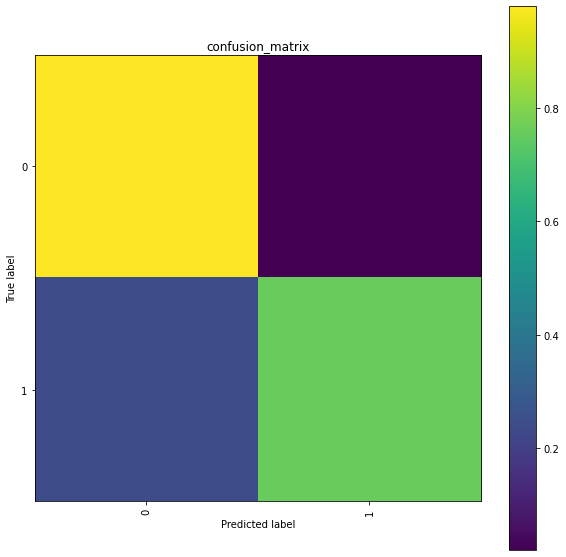

In [37]:
#getting confusion matrix
cm_rf = confusion_matrix(test1_y,y_pred_rf)
print('confusion matrix:\n',cm_rf)
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]  
print('confusion matrix:\n',cm_rf)
labels = [0,1]  
plot_confusion_matrix(cm_rf,labels,'confusion_matrix')
print(SkM.classification_report(test1_y,y_pred_rf))

Dataset 2

confusion matrix:
 [[316   6]
 [ 15 104]]
confusion matrix:
 [[0.98 0.02]
 [0.13 0.87]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       322
           1       0.95      0.87      0.91       119

    accuracy                           0.95       441
   macro avg       0.95      0.93      0.94       441
weighted avg       0.95      0.95      0.95       441



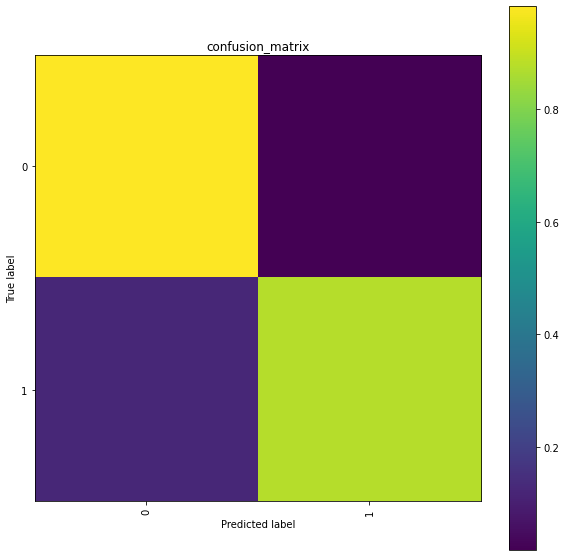

In [39]:
rf_model = SkE.RandomForestClassifier(random_state=0, class_weight='balanced')
rf_model.fit(train2_x, train2_y)
#prediction of training dataset
y_pred_rf2 = rf_model.predict(test2_x)
#getting confusion matrix
cm_rf2 = confusion_matrix(test2_y,y_pred_rf2)
print('confusion matrix:\n',cm_rf2)
cm_rf2 = cm_rf2.astype('float') / cm_rf2.sum(axis=1)[:, np.newaxis]    
print('confusion matrix:\n',cm_rf2)
labels = [0,1]  #set of label
plot_confusion_matrix(cm_rf2,labels,'confusion_matrix')
print(SkM.classification_report(test2_y,y_pred_rf2))

### Model 2 Logistic model

dataset1

In [40]:
log_model = SkLm.LogisticRegression(random_state=0, n_jobs=31, class_weight='balanced')
log_model.fit(train1_x, train1_y)
#prediction of training dataset
y_pred_log1 = log_model.predict(test1_x)

confusion matrix:
 [[287  35]
 [ 14 105]]
confusion matrix:
 [[0.89 0.11]
 [0.12 0.88]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       322
           1       0.75      0.88      0.81       119

    accuracy                           0.89       441
   macro avg       0.85      0.89      0.87       441
weighted avg       0.90      0.89      0.89       441



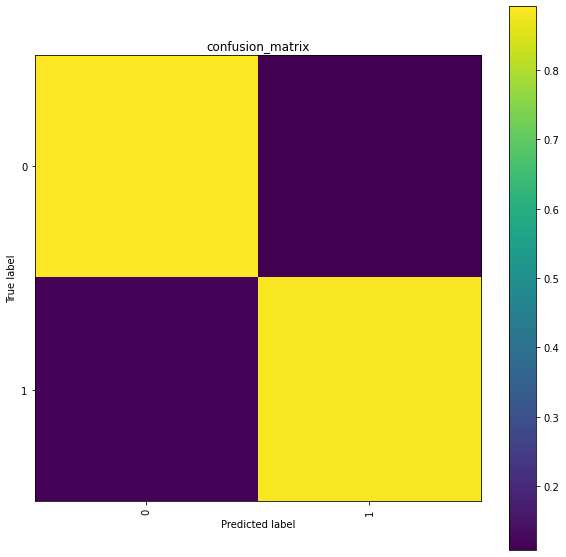

In [41]:
#getting confusion matrix
from sklearn.metrics import confusion_matrix,classification_report
cm_log1 = confusion_matrix(test1_y,y_pred_log1)
print('confusion matrix:\n',cm_log1)
cm_log1 = cm_log1.astype('float') / cm_log1.sum(axis=1)[:, np.newaxis]    
print('confusion matrix:\n',cm_log1)
labels = [0,1] 
plot_confusion_matrix(cm_log1,labels,'confusion_matrix')
print(SkM.classification_report(test1_y,y_pred_log1))

Dataset2

confusion matrix:
 [[296  26]
 [ 14 105]]
confusion matrix:
 [[0.92 0.08]
 [0.12 0.88]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       322
           1       0.80      0.88      0.84       119

    accuracy                           0.91       441
   macro avg       0.88      0.90      0.89       441
weighted avg       0.91      0.91      0.91       441



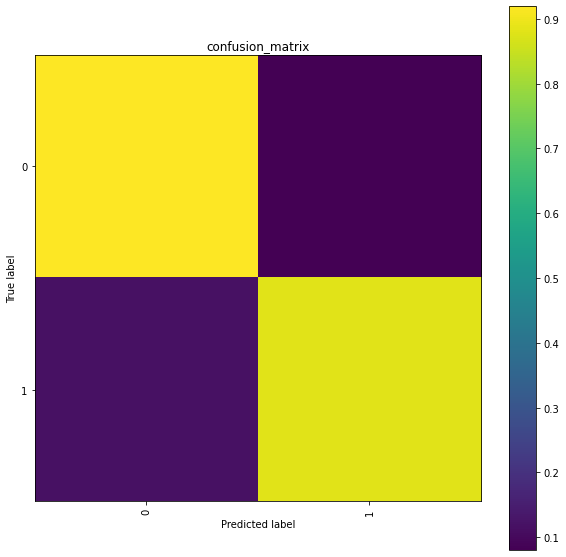

In [48]:
log_model = SkLm.LogisticRegression(random_state=0, n_jobs=31, class_weight='balanced')
log_model.fit(train2_x, train2_y)
#prediction of training dataset
y_pred_log2 = log_model.predict(test2_x)
#getting confusion matrix
cm_log2 = confusion_matrix(test2_y,y_pred_log2)
print('confusion matrix:\n',cm_log2)
cm_log2 = cm_log2.astype('float') / cm_log2.sum(axis=1)[:, np.newaxis]    
print('confusion matrix:\n',cm_log2)
labels = [0,1] 
plot_confusion_matrix(cm_log2,labels,'confusion_matrix')
print(SkM.classification_report(test2_y,y_pred_log2))

### Tensorflow model

split trainset again to get the proper step

In [49]:
#split first dataset in advance
train_data1,step_test1 = train_test_split(train_data_1, test_size=0.2)
train1_x = train_data1.iloc[:,0:32]
train1_y = train_data1.iloc[:,32]
step1_x = step_test1.iloc[:,0:32]
step1_y = step_test1.iloc[:,32]

In [50]:
#second dataset
train_data2,step_test2 = train_test_split(train_data_2, test_size=0.2)
train2_x = train_data2.iloc[:,0:32]
train2_y = train_data2.iloc[:,32]
step2_x = step_test2.iloc[:,0:32]
step2_y = step_test2.iloc[:,32]

run_model

first_dataset

In [184]:
x_array = np.array(train1_x).astype('float')
train1_x = torch.tensor(x_array)
y_array = np.array(train1_y).astype('long')
train1_y = torch.tensor(y_array)

xt_array = np.array(step1_x).astype('float')
step1_x = torch.tensor(xt_array)
xt_array = np.array(test1_x).astype('float')
test1_x = torch.tensor(xt_array)
total_step = 200

b = list(range(1,31))

In [196]:
import random
# SGD method
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
netv1 = NeuralNet(32, 9, 2)
cr = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(netv1.parameters(), lr=.02)

In [197]:
for j in range(31):
    for i in range(total_step):
        outputs = netv1(train1_x.float())
        loss = cr(outputs, train1_y.long())
        optimizer.zero_grad() # # Gradient reset
        loss.backward() #For loss function BP
        optimizer.step()
    with torch.no_grad():
        out = netv1(step1_x.float())
        _, predicted = torch.max(out.data, 1)
        pre = predicted.numpy().tolist()
    b[j-1] = "{:.3f}".format(f1_score(step1_y, pre))

In [198]:
(b.index(max(b))+1)*200

1800

In [199]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
netv1 = NeuralNet(32, 9, 2)
cr = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(netv1.parameters(), lr=.02)
for i in range(1800):
    outputs = netv1(train1_x.float())
    loss = cr(outputs, train1_y.long())
    optimizer.zero_grad() #
    loss.backward() 
    optimizer.step()
with torch.no_grad():
    out = netv1(test1_x.float())
    _, predicted = torch.max(out.data, 1)
    pre = predicted.numpy().tolist()

confusion matrix:
 [[0.97 0.03]
 [0.17 0.83]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       322
           1       0.91      0.83      0.87       119

    accuracy                           0.93       441
   macro avg       0.92      0.90      0.91       441
weighted avg       0.93      0.93      0.93       441



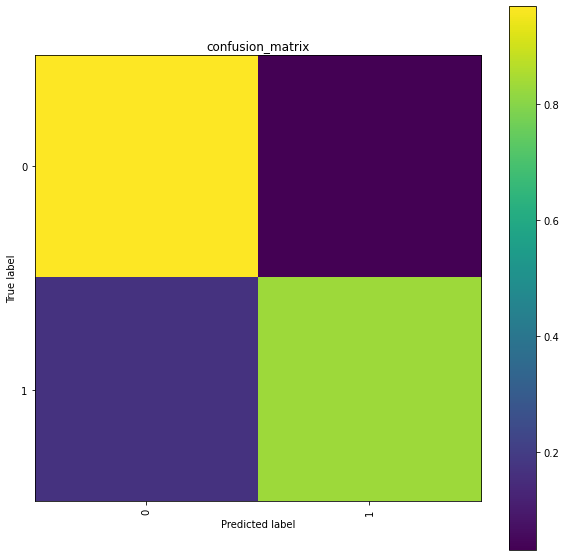

In [200]:
cm_tf1 = confusion_matrix(test1_y,pre)
cm_tf1 = cm_tf1.astype('float') / cm_tf1.sum(axis=1)[:, np.newaxis]    
print('confusion matrix:\n',cm_tf1)
labels = [0,1]  
plot_confusion_matrix(cm_tf1,labels,'confusion_matrix')
print(SkM.classification_report(test1_y,pre))

Dataset 2

In [178]:
x_array = np.array(train2_x).astype('float')
train2_x = torch.tensor(x_array)
y_array = np.array(train2_y).astype('long')
train2_y = torch.tensor(y_array)

xt_array = np.array(step2_x).astype('float')
step2_x = torch.tensor(xt_array)
xt_array = np.array(test2_x).astype('float')
test2_x = torch.tensor(xt_array)
total_step = 200

b = list(range(1,31))

In [179]:
# SGD method
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
netv1 = NeuralNet(32, 9, 2)
cr = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(netv1.parameters(), lr=.02)
for j in range(31):
    for i in range(total_step):
        outputs = netv1(train2_x.float())
        loss = cr(outputs, train2_y.long())
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
    with torch.no_grad():
        out = netv1(step2_x.float())
        _, predicted = torch.max(out.data, 1)
        pre2 = predicted.numpy().tolist()
    b[j-1] = "{:.3f}".format(f1_score(step2_y, pre2))

In [180]:
b.index(max(b))*200

5400

In [181]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
netv1 = NeuralNet(32, 9, 2)
cr = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(netv1.parameters(), lr=.02)
for i in range(5400):
    outputs = netv1(train2_x.float())
    loss = cr(outputs, train2_y.long())
    optimizer.zero_grad() # 梯度清零
    loss.backward() # 对损失函数BP
    optimizer.step()
with torch.no_grad():
    out = netv1(test2_x.float())
    _, predicted = torch.max(out.data, 1)
    pre2 = predicted.numpy().tolist()

confusion matrix:
 [[0.97 0.03]
 [0.14 0.86]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       322
           1       0.90      0.86      0.88       119

    accuracy                           0.94       441
   macro avg       0.93      0.91      0.92       441
weighted avg       0.94      0.94      0.94       441



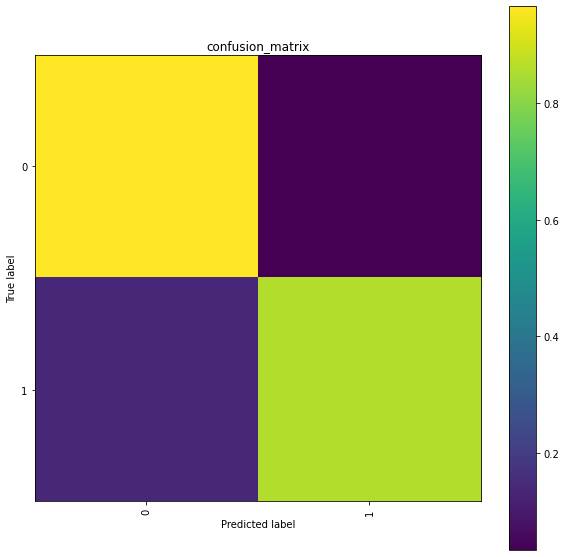

In [183]:
cm_tf2 = confusion_matrix(test2_y,pre2)
cm_tf2 = cm_tf2.astype('float') / cm_tf2.sum(axis=1)[:, np.newaxis]    # 归一化
print('confusion matrix:\n',cm_tf2)
labels = [0,1]  #类别集合
plot_confusion_matrix(cm_tf2,labels,'confusion_matrix')
print(SkM.classification_report(test2_y,pre2))